In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from datetime import date, datetime, timedelta
import xarray as xr
import netCDF4 as nc
import glob
import calendar
import os
#from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import scipy.stats
import math
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from functions_for_vis_data_analysis import plot_maps, plot_hist, plot_hist_freq, plot_maps_nocolorbar
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

/home/users/jawahm/.conda/envs/hackathon/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
dir_name = '/gws/nopw/j04/parachute/ukceh/mtg_vis/' 
ds = xr.open_dataset(dir_name+'FCIL1HRFI_20250410T110352Z_20250410T110550Z_epct_ddfd3c6c_FPRC.nc')
lat = ds['lat'].values
lon = ds['lon'].values
hr_of_analysis= 11

In [3]:
# load initiation file into panda dataset
df = pd.read_csv('../conv_init_data/init_202504_T40_vn2_30km.txt', sep=r'\s+')
#lat_conv_init = df['latN_c']
#lon_conv_init = df['lonE_c']
#hr_of_conv = df['hr']#+3 # converted to local time
#min_temp = df['minT']
# filter for 1st april 2025
xlim = ([np.min(lon), np.max(lon)])
ylim = ([np.min(lat), np.max(lat)])
filtered_df = df[(df['latN_c']<np.max(lat)) & (df['latN_c']>np.min(lat)) & (df['lonE_c']<np.max(lon)) & (df['lonE_c']>np.min(lon))]
filtered_df = filtered_df[filtered_df['hr'] == hr_of_analysis]
#filtered_df = filtered_df[filtered_df['mn'] == 0]


In [ ]:
# approx pixel area = 2 to 3 km2
quantiles = [.99]
vis_events=[]
min_temp_of_events=[]
for d in range(1,31):
    hr_vis=[]
    hr_norm_vis=[]
    list_of_files=sorted(glob.glob(dir_name+"FCI*04"+str(d).zfill(2)+"T"+str(hr_of_analysis).zfill(2)+"*.nc"))
    vis = []
    for i in list_of_files:
        ds = xr.open_dataset(i)
        vis.append(ds['vis_06_hr_effective_radiance'].values)
    mean_vis_for_hr_tmp = np.mean(np.array(vis),axis=0)
    # Calculate the percentiles
    mean_vis_for_hr= mean_vis_for_hr_tmp[~np.isnan(mean_vis_for_hr_tmp)]
    normalizing_factor_for_hr = np.quantile(mean_vis_for_hr, quantiles)
    hr_vis=mean_vis_for_hr_tmp
    hr_norm_vis=mean_vis_for_hr_tmp/normalizing_factor_for_hr
    # read in init for that day at hour of analysis
    subset_filtered_df_day = filtered_df[filtered_df['dy'] == d]
    for nrow in range(0,subset_filtered_df_day.shape[0]):
        one_event =subset_filtered_df_day.iloc[nrow]
        lat_conv_init =  one_event['latN_c']
        lon_conv_init = one_event['lonE_c']
       # hr_of_conv =  one_event['hr']  #+3 # converted to local time
        
        # find location in vis data
        lat_ind = np.where((lat>lat_conv_init-0.0075) & (lat<lat_conv_init+0.0075))[0][0] #30 grids- total 60 pixels ~ 50km
        lon_ind = np.where((lon>lon_conv_init-0.0075) & (lon<lon_conv_init+0.0075))[0][0]
        if lat_ind-60>0 and lat_ind+60< lat.shape[0] and lon_ind-60>0 and lon_ind+60< lon.shape[0]:
            vis_events.append(hr_norm_vis[int(lat_ind-60):int(lat_ind+60),int(lon_ind-60):int(lon_ind+60)])
            min_temp_of_events.append(one_event['minT'])

vis_events=np.array(vis_events)#.shape     
#vis_lat = lat[lat_ind[0]:lat_ind[-1]+1]
        #vis_lon = lon[lat_ind[0]:lat_ind[-1]+1]

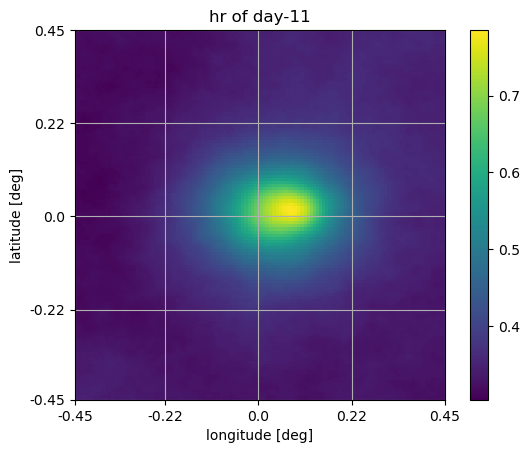

In [7]:
labels = np.round(np.arange(-0.0075*60,0.0075*60+0.0075,0.0075*30),2)

#plt.imshow(np.nanmean(vis_events,axis=0),vmin=0, vmax=1)
plt.imshow(np.nanmean(vis_events,axis=0))
plt.colorbar()
plt.yticks([0, 30-1, 60-1, 90-1, 120-1], labels)
plt.xticks([0, 30-1, 60-1, 90-1, 120-1], labels)
plt.xlim([0,119])
plt.ylim([0,119])
plt.xlabel('longitude [deg]')
plt.ylabel('latitude [deg]')
plt.title('hr of day-'+str(hr_of_analysis))
plt.grid()